In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import model_selection, preprocessing,linear_model, metrics, pipeline , ensemble,neighbors

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = [10.0, 6.0]

%matplotlib inline

In [3]:
train = pd.read_csv('../../datasets/titanic/train.csv')
test = pd.read_csv('../../datasets/titanic/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [37]:
def marital_status(cols):
    name = cols['Name']
    if "Mr." in name or "Mrs." in name:
        return "married"
    elif "Miss." in name or "Master." in name:
        return "unmarried"
    else:
        return "unknown"

def family_size(cols):
    member_count = cols['Parch'] + cols['SibSp'] + 1
    if member_count <= 1:
        return "single"
    elif member_count > 1 and member_count < 5:
        return "smallFamily"
    else:
        return "largeFamily"

def fareClass(cols):
    fare = cols['Fare']
    if (fare <= 15):
        return 'lo'
    elif ((fare > 15) & (fare <= 130)):
        return 'medium'
    elif ((fare > 130) & (fare <= 250)):
        return 'high'
    else:
        return 'super-high'

def featureEngineering(df):
    # Data type conversion
    df['Pclass'] = df['Pclass'].astype('object')
    
    # new column addition
    df['Martal_status'] = df.apply(marital_status,axis=1)
    df['Family_Size'] = df.apply(family_size,axis=1)
    df['Fare_Class'] = df.apply(fareClass,axis=1)
    return df

In [38]:
train = featureEngineering(train)
test = featureEngineering(test)

In [39]:
# train['Pclass'] = train['Pclass'].astype('object')
# test['Pclass'] = test['Pclass'].astype('object')
# ## Feature engineering
# train['Martal_status'] = train.apply(marital_status,axis=1)
# train['Family_Size'] = train.apply(family_size,axis=1)
# train['Fare_Class'] = train.apply(fareClass,axis=1)

# test['Martal_status'] = test.apply(marital_status,axis=1)
# test['Family_Size'] = test.apply(family_size,axis=1)
# test['Fare_Class'] = test.apply(fareClass,axis=1)

In [40]:
target = 'Survived'
features = list(train.columns)
features.remove('PassengerId')
features.remove('Name')
features.remove('Cabin')
features.remove('Ticket')
features.remove('Parch')
features.remove('SibSp')
features.remove('Fare')
features.remove(target)
features , target

(['Pclass',
  'Sex',
  'Age',
  'Embarked',
  'Martal_status',
  'Family_Size',
  'Fare_Class'],
 'Survived')

In [41]:
medians = train.dropna().groupby('Pclass')['Age'].median()
for i in train[train['Age'].isnull()].index:
    train.loc[i,'Age'] = medians[train.loc[i,'Pclass']]
    
for i in test[test['Age'].isnull()].index:
    test.loc[i,'Age'] = medians[test.loc[i,'Pclass']]
    
max_fare = np.max(train['Fare'])
fare_mean = train[train.Fare != max_fare].Fare.mean()
for i in test[test['Fare'].isnull()].index:
    test.loc[i,'Fare'] = fare_mean

In [42]:
def preprocess(df,features = None,target = None):
    X = df.loc[:,features]
    X = pd.get_dummies(X, drop_first= True)
    y = []
    if target != None:
        y = df.loc[:,target]
    
    return X,y

In [43]:
def lr_model(train_X,train_y,test_X):
    est = pipeline.Pipeline([
        ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", preprocessing.StandardScaler()),
        ("lr", linear_model.LogisticRegression(random_state=1,penalty='l1'))
    ])
    est.fit(train_X,train_y)

    y_train_pred = est.predict(train_X)
    y_train_prob = est.predict_proba(train_X)[:,1]
    
    y_test_pred = est.predict(test_X)
    y_test_prob = est.predict_proba(test_X)[:,1]
    return y_train_prob,y_test_prob

def rf_model(train_X,train_y,test_X):
    est = pipeline.Pipeline([
#         ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
#         ("scaler", preprocessing.StandardScaler()),
        ("rf", ensemble.RandomForestClassifier(random_state=1))
    ])
    est.fit(train_X,train_y)

    y_train_pred = est.predict(train_X)
    y_train_prob = est.predict_proba(train_X)[:,1]
    
    y_test_pred = est.predict(test_X)
    y_test_prob = est.predict_proba(test_X)[:,1]
    return y_train_prob,y_test_prob

def knn_model(train_X,train_y,test_X):
    est = pipeline.Pipeline([
#         ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", preprocessing.StandardScaler()),
        ("knn", neighbors.KNeighborsClassifier(n_neighbors=10))
    ])
    est.fit(train_X,train_y)

    y_train_pred = est.predict(train_X)
    y_train_prob = est.predict_proba(train_X)[:,1]
    
    y_test_pred = est.predict(test_X)
    y_test_prob = est.predict_proba(test_X)[:,1]
    return y_train_prob,y_test_prob

def ensemble_model(train_X,train_y,test_X):
    clf1 = pipeline.Pipeline([
#         ("poly", preprocessing.PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", preprocessing.StandardScaler()),
        ("lr", linear_model.LogisticRegression(random_state=1,penalty='l1'))
    ])
    
    clf2 = pipeline.Pipeline([
        ("rf", ensemble.RandomForestClassifier(random_state=1))
    ])
    
    clf3 = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("knn", neighbors.KNeighborsClassifier(n_neighbors=10))
    ])
    
    est = ensemble.VotingClassifier(estimators=[("lr",clf1),("rf",clf2),("knn",clf3)],voting='soft')
    est.fit(train_X,train_y)

    y_train_pred = est.predict(train_X)
    y_train_prob = est.predict_proba(train_X)[:,1]
    
    y_test_pred = est.predict(test_X)
    y_test_prob = est.predict_proba(test_X)[:,1]
    return y_train_prob,y_test_prob

In [44]:
def print_val(y_test,y_pred_prob,threshold = 0.5):
    y_test_pred = np.where(y_pred_prob > threshold , 1, 0)
    
    print("Accuracy :: %.3f" % metrics.accuracy_score(y_true=y_test,y_pred=y_test_pred))
    print("Precision :: %.3f" % metrics.precision_score(y_true=y_test,y_pred=y_test_pred))
    print("Recall :: %.3f" % metrics.recall_score(y_true=y_test,y_pred=y_test_pred))
    
    confusion_matrix = metrics.confusion_matrix(y_true=y_test,y_pred=y_test_pred)
    print(confusion_matrix)
    return
    

In [45]:
X,y = preprocess(train,features=features,target=target)

In [46]:
X.shape,y.shape

((891, 13), (891,))

In [47]:
X.head()

,Age,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Martal_status_unknown,Martal_status_unmarried,Family_Size_single,Family_Size_smallFamily,Fare_Class_lo,Fare_Class_medium,Fare_Class_super-high
0,22.0,0,1,1,0,1,0,0,0,1,1,0,0
1,38.0,0,0,0,0,0,0,0,0,1,0,1,0
2,26.0,0,1,0,0,1,0,1,1,0,1,0,0
3,35.0,0,0,0,0,1,0,0,0,1,0,1,0
4,35.0,0,1,1,0,1,0,0,1,0,1,0,0


In [48]:
X_train, X_test, y_train,y_test = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 1)

In [49]:
lr_train_prob,lr_test_prob = lr_model(X_train,y_train,X_test)
rf_train_prob,rf_test_prob = rf_model(X_train,y_train,X_test)
knn_train_prob,knn_test_prob = knn_model(X_train,y_train,X_test)
ensemble_train_prob,ensemble_test_prob = ensemble_model(X_train,y_train,X_test)

E:\AppData\Local\Continuum\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\AppData\Local\Continuum\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,1,'ROC, auc: 0.850583')

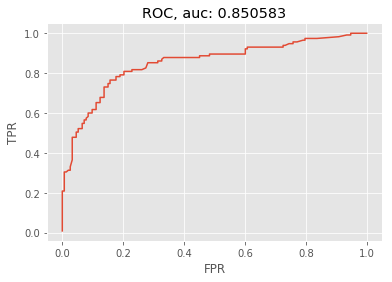

In [50]:
fpr, tpr, threshold = metrics.roc_curve(y_test, ensemble_test_prob)

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC, auc: %f" % (metrics.auc(fpr, tpr)))

In [51]:
threshold = 0.45
y_train_prob = ensemble_train_prob 
y_test_prob = ensemble_test_prob
print("--------Train------------")
print_val(y_train,y_train_prob,threshold)
print("--------Test------------")
print_val(y_test,y_test_prob,threshold)

--------Train------------
Accuracy :: 0.902
Precision :: 0.888
Recall :: 0.837
[[372  24]
 [ 37 190]]
--------Test------------
Accuracy :: 0.791
Precision :: 0.792
Recall :: 0.696
[[132  21]
 [ 35  80]]


In [52]:
X_submission,y_submission = preprocess(test,features=features)

In [53]:
_,y_submission_prob = ensemble_model(train_X = X,train_y=y,test_X=X_submission)
y_test_pred = np.where(y_submission_prob > threshold , 1, 0)

E:\AppData\Local\Continuum\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\AppData\Local\Continuum\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [55]:
# test.shape,len(y_test_pred),len(a),len(y_submission_prob),X_submission.shape

In [56]:
test['Survived'] = y_test_pred

In [57]:
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Martal_status,Family_Size,Fare_Class,Survived
276,1168,2,"Parker, Mr. Clifford Richard",male,28.0,0,0,SC 14888,10.5000,NaN,S,married,single,lo,0
63,955,3,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,unmarried,single,lo,1
412,1304,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,unmarried,single,lo,1
151,1043,3,"Matinoff, Mr. Nicola",male,24.5,0,0,349255,7.8958,NaN,C,married,single,lo,0
121,1013,3,"Kiernan, Mr. John",male,24.5,1,0,367227,7.7500,NaN,Q,married,smallFamily,lo,0


In [ ]:
submission = pd.read_csv('../../datasets/titanic/gender_submission.csv')
submission.head()

In [ ]:
test[['PassengerId','Survived']].to_csv("gender_submission.csv",index=False)